# 목차

0) 모듈 import 및 버전확인<br>1) 데이터 준비와 확인<br>
2) 데이터로더 구성<br>
3) 모델 구성을 위한 데이터 분석 및 가공<br>
4) 모델 구성 및 validation set 구성<br>
5) 모델 훈련 개시 및 <br>
6) Loss, Accuracy 그래프 시각화<br>
7) 학습된 Embedding 레이어 <br>
8) 한국어 Word2Vec 임베딩 활용하여 성능 개선<br>
9) 회고

# 0) 모듈 import

In [2]:
import os
import re
import pandas as pd #행렬로 이루어진 객체를 만들어 대용량 데이터를 처리
import numpy as np #array 단위로 벡터와 행렬을 계산
from collections import Counter #collections의 counter는 합산하는 기능(계산) 데이터 처리 라이브러리
import matplotlib.pyplot as plt #시각화
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import urllib.request

In [3]:
import konlpy #한국어 처리를 위한 오픈소스 라이브러리. 미캡, okt, 꼬꼬마, 코모란, 한나눔 등이 있음
from konlpy.tag import Okt #(구)트위터 형태소 분석기
from konlpy.tag import Mecab #일본어 형태소 분석기를 '은전한닢' 프로젝트로 한국어로 포팅함.

In [4]:
import tensorflow as tf
from tensorflow import keras #keras는 텐서플로 위에서 작동하는 라이브러리, 딥러닝 기본 연산 기능
from tensorflow.keras.preprocessing.text import Tokenizer #토크나이저
from tensorflow.keras.preprocessing.sequence import pad_sequences #pad sequnece는 특정 값을 채워서 데이터의 shape(크기)를 조정
from tensorflow.keras.initializers import Constant #initializer는 케라스 레이어 파라미터 초깃값을 어떤방식으로 생성할 것인지 결정, constant는 파라미터를 특정 상수값으로 생성
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #ES 는 loss값이 더 이상 감소하지 않으면 학습을 중단 #modelcheckpoint는 모델을 학습시키는 동안 이포크마다 자동으로 저장
from tensorflow.keras.models import load_model #Model은 멀티 인풋/아웃풋을 다룬다

In [5]:
import gensim #자연어를 벡터로 변환하는 기능 제공 오픈소스 라이브러리
from gensim.models import KeyedVectors #keyedvectors는 워드벡트롤 저장하고 query함. query는 db에 특정 데이터를 보여달라는 요청을 하는 것
from gensim.models.keyedvectors import Word2VecKeyedVectors #key와 벡터를 매핑

## 버전확인

In [6]:
print(pd.__version__)
print(np.__version__)
print(keras.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
1.21.4
2.6.0
0.5.2
3.8.1


# 1) 데이터 준비와 확인

In [7]:
## tokenizer, 불용어 선언
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [8]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #데이터의 중복 제거
    train_data = train_data.dropna(how = 'any')                   #NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어(Stopwords) 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  #한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어(Stopwords) 제거
        X_test.append(temp_X)
    
    #사전word_to_index 구성
    words = np.concatenate(X_train).tolist() #단어 numpy 배열을 하나로 합침
    counter = Counter(words) #단어의 수 합산
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #몇 번째 반복문인지 확인
    
    #텍스트 스트링을 사전 인덱스 스트링으로 변환    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
# visualization Loss & Accuracy by epochs
def visualization(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # Loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.clf()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
# model을 훈련시키고 평가해보는 함수
def fitting_machine(model,epoch):
    # model compile
    model = model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # model training and recording history
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epoch,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)
    # print result
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'\nThis is {model.name}\nLoss: {results[0]}\nAccurancy: {results[1]}\n')
    
    return history

# 2) 데이터로더 구성

In [12]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
# data load 하여 X_train, y_train, X_test, y_test, word_to_index 리턴
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [14]:
# index에서 word로 바꿔주는 dictionary
index_to_word = {index:word for word, index in word_to_index.items()}

In [15]:
len(word_to_index)

10000

In [16]:
# function, data 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 3) 모델 구성을 위한 데이터 분석 및 가공

In [17]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [19]:
from sklearn.model_selection import train_test_split

# Train, val data 분리
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1997)

# 4) 모델 구성 및 validation set 구성

In [20]:
class LSTMModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 128
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.lstm = keras.layers.LSTM(128)
        self.dense = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense(x)
        
        return x

In [21]:
lstm_model = LSTMModel()

# 5) 모델 훈련 개시 및 6) Loss, Accuracy 그래프 시각화

In [22]:
lstm_history = fitting_machine(lstm_model, 5)

Epoch 1/5
3427/3427 [==============================] - 23s 6ms/step - loss: 0.3716 - accuracy: 0.8340 - val_loss: 0.3222 - val_accuracy: 0.8602
Epoch 2/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2849 - accuracy: 0.8792 - val_loss: 0.3144 - val_accuracy: 0.8640
Epoch 3/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2416 - accuracy: 0.9000 - val_loss: 0.3437 - val_accuracy: 0.8639
Epoch 4/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2014 - accuracy: 0.9176 - val_loss: 0.3539 - val_accuracy: 0.8628
Epoch 5/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.1629 - accuracy: 0.9352 - val_loss: 0.4082 - val_accuracy: 0.8563
1537/1537 - 3s - loss: 0.4109 - accuracy: 0.8547

This is lstm_model
Loss: 0.4109402894973755
Accurancy: 0.8546900749206543



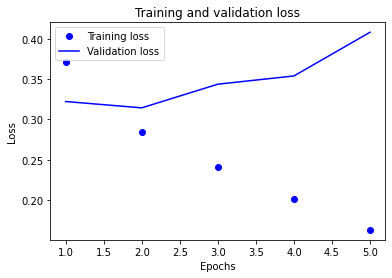

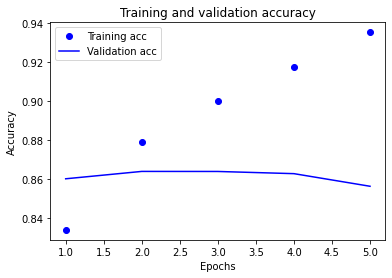

In [23]:
visualization(lstm_history)

In [24]:
class Conv1DModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 64
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.conv1 = keras.layers.Conv1D(64, 7, activation='relu')
        self.maxp = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(64, 7, activation='relu')
        self.gmaxp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.gmaxp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [25]:
conv1d_model = Conv1DModel()

In [26]:
conv1d_history = fitting_machine(conv1d_model, 5)

Epoch 1/5
3427/3427 [==============================] - 18s 5ms/step - loss: 0.3703 - accuracy: 0.8306 - val_loss: 0.3271 - val_accuracy: 0.8588
Epoch 2/5
3427/3427 [==============================] - 16s 5ms/step - loss: 0.2626 - accuracy: 0.8904 - val_loss: 0.3293 - val_accuracy: 0.8594
Epoch 3/5
3427/3427 [==============================] - 16s 5ms/step - loss: 0.1788 - accuracy: 0.9294 - val_loss: 0.3851 - val_accuracy: 0.8528
Epoch 4/5
3427/3427 [==============================] - 16s 5ms/step - loss: 0.1115 - accuracy: 0.9573 - val_loss: 0.4607 - val_accuracy: 0.8498
Epoch 5/5
3427/3427 [==============================] - 16s 5ms/step - loss: 0.0767 - accuracy: 0.9717 - val_loss: 0.5778 - val_accuracy: 0.8458
1537/1537 - 3s - loss: 0.5908 - accuracy: 0.8423

This is conv1d_model
Loss: 0.5907921195030212
Accurancy: 0.8423418998718262



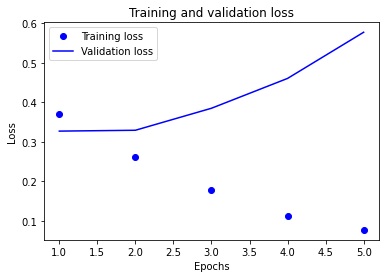

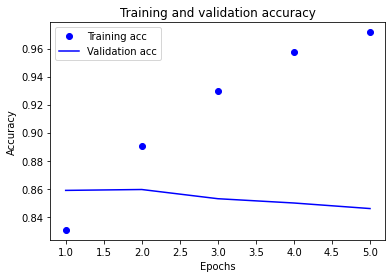

In [27]:
visualization(conv1d_history)

In [28]:
class GMPModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 64
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.gmp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [29]:
gmp_model = GMPModel()

In [30]:
gmp_history = fitting_machine(gmp_model, 5)

Epoch 1/5
3427/3427 [==============================] - 12s 3ms/step - loss: 0.3966 - accuracy: 0.8204 - val_loss: 0.3495 - val_accuracy: 0.8464
Epoch 2/5
3427/3427 [==============================] - 11s 3ms/step - loss: 0.3056 - accuracy: 0.8708 - val_loss: 0.3459 - val_accuracy: 0.8499
Epoch 3/5
3427/3427 [==============================] - 11s 3ms/step - loss: 0.2649 - accuracy: 0.8907 - val_loss: 0.3620 - val_accuracy: 0.8490
Epoch 4/5
3427/3427 [==============================] - 11s 3ms/step - loss: 0.2294 - accuracy: 0.9085 - val_loss: 0.3734 - val_accuracy: 0.8455
Epoch 5/5
3427/3427 [==============================] - 11s 3ms/step - loss: 0.1968 - accuracy: 0.9237 - val_loss: 0.4011 - val_accuracy: 0.8445
1537/1537 - 2s - loss: 0.4086 - accuracy: 0.8416

This is gmp_model
Loss: 0.40859636664390564
Accurancy: 0.8416298627853394



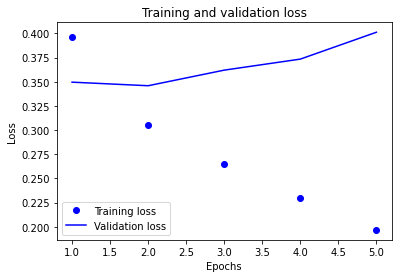

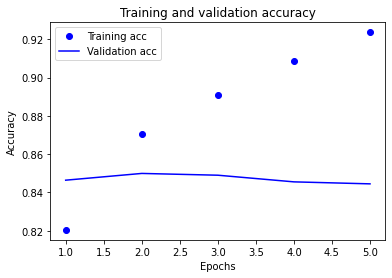

In [31]:
visualization(gmp_history)

# 7) 학습된 Embedding 레이어 분석

## Lstm emdeding layer

In [32]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.02835404,  0.1645078 ,  0.01121133, -0.08000896, -0.25150907,
        0.06241269,  0.16736275, -0.11005669, -0.26340833, -0.25228956,
        0.22905946,  0.01514502, -0.06445399,  0.1026145 ,  0.02206293,
       -0.16303122, -0.08479652, -0.10392562,  0.12745626,  0.2635292 ,
        0.10555435,  0.13379838, -0.08047791,  0.16732255,  0.07010064,
       -0.18282223, -0.05690211, -0.17357524, -0.04622746, -0.03795951,
        0.00200337,  0.25660422, -0.09396044, -0.08297278,  0.07668479,
       -0.26197645,  0.03367444, -0.08705325, -0.16774637,  0.07392482,
       -0.02575775, -0.03419096,  0.03766603, -0.08793107, -0.00225837,
        0.04705795, -0.11473507, -0.14028415,  0.02969255,  0.01636566,
        0.20997994,  0.04586617, -0.06098553, -0.15312468,  0.07822841,
       -0.07157072, -0.10344923, -0.08842513,  0.0110314 ,  0.16901837,
        0.01016792,  0.22820015, -0.16939443,  0.04689233, -0.11465204,
        0.19690937, -0.10896326, -0.03877384, -0.0552173 , -0.00

In [33]:
# lstm model을 통하여 만든 vector "사랑"과 비슷한 단어들
word_vectors.similar_by_word("사랑")

[('멋있', 0.9086006879806519),
 ('굵', 0.888211727142334),
 ('살아온', 0.8838387131690979),
 ('순수', 0.8826274871826172),
 ('완벽', 0.8816320896148682),
 ('음악', 0.8802470564842224),
 ('상큼', 0.8800019025802612),
 ('생각났', 0.8799525499343872),
 ('동전', 0.8763893842697144),
 ('릿', 0.8763429522514343)]

In [34]:
# lstm model을 통하여 만든 vector "열정"과 비슷한 단어들
word_vectors.similar_by_word("열정")

[('스포일러', 0.8838138580322266),
 ('후유증', 0.8788735866546631),
 ('아쉬울', 0.8683719635009766),
 ('오염', 0.8595520853996277),
 ('검색어', 0.8589731454849243),
 ('퍼시픽', 0.8585322499275208),
 ('요세', 0.8584269285202026),
 ('한석규', 0.8571860790252686),
 ('언젠가', 0.8557262420654297),
 ('지킬', 0.8555209636688232)]

## Conv1D emdeding layer

In [35]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.03577223, -0.10315147, -0.08919736, -0.02178557, -0.2212902 ,
        0.13273537, -0.0645867 , -0.26236627,  0.03018584, -0.07393503,
       -0.05081623,  0.08758239, -0.07106979,  0.10701089,  0.02256427,
        0.0040073 , -0.00726136,  0.11135294, -0.3021454 , -0.17400049,
        0.14607802, -0.1239908 , -0.09179515, -0.10680385, -0.11928046,
        0.04498715, -0.22927998, -0.00136537,  0.09193648, -0.2718174 ,
       -0.13192822,  0.02887841, -0.14960241,  0.2695042 ,  0.11147667,
       -0.17273158, -0.24476384, -0.2877589 ,  0.06707874, -0.00068218,
       -0.03483233,  0.02048821, -0.09715389,  0.21431573,  0.13961212,
        0.05128534,  0.09729401,  0.30300158, -0.15488057,  0.1044777 ,
       -0.04363055, -0.11035632, -0.15609592, -0.10375503,  0.09871038,
        0.1413354 ,  0.05931864, -0.2701037 , -0.00664988,  0.02388495,
       -0.05770919, -0.16592368, -0.027223  , -0.09781248], dtype=float32)

In [36]:
# conv1d model을 통하여 만든 vector "사랑"과 비슷한 단어들
word_vectors.similar_by_word("사랑")

[('황정음', 0.7055032253265381),
 ('very', 0.7031189799308777),
 ('음미', 0.6871731281280518),
 ('돋보이', 0.6768398284912109),
 ('클레이', 0.6743072271347046),
 ('최상', 0.6679523587226868),
 ('넘쳤', 0.6676403880119324),
 ('다가오', 0.6665335893630981),
 ('민중', 0.664551317691803),
 ('이제서야', 0.6642042398452759)]

In [37]:
# conv1d model을 통하여 만든 vector "열정"과 비슷한 단어들
word_vectors.similar_by_word("열정")

[('오염', 0.744185209274292),
 ('어쩌면', 0.7307816743850708),
 ('황홀', 0.7202563285827637),
 ('다가왔', 0.711315929889679),
 ('새로운', 0.7094326615333557),
 ('기업', 0.7063686847686768),
 ('케이온', 0.7040711045265198),
 ('해운대', 0.7031282186508179),
 ('웃긴데', 0.7010766863822937),
 ('넘침', 0.6997833251953125)]

## GMP emdeding layer

In [38]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.05864885, -0.00746158,  0.01729929, -0.05356904, -0.05581032,
       -0.10583433, -0.02333442,  0.07439687, -0.09978232, -0.01156008,
       -0.02608579, -0.15669271, -0.06024295,  0.12198117, -0.01563872,
       -0.03342143, -0.01769132, -0.00520483,  0.02691951, -0.01735497,
        0.10344644, -0.16595808,  0.02692569, -0.08936939,  0.0742785 ,
       -0.04411529, -0.032779  , -0.15108353, -0.14010414, -0.13522743,
       -0.02513538, -0.13764401,  0.03200091, -0.07855991, -0.10195132,
        0.02165587, -0.09774052, -0.04659587,  0.07540133, -0.12351625,
       -0.01405342, -0.03227245,  0.11392381, -0.05818687, -0.13790181,
       -0.10725163,  0.08109328, -0.04063277,  0.02683541,  0.02280373,
       -0.04386955, -0.09854634, -0.0224944 , -0.07328741, -0.13025773,
       -0.16706131, -0.10755274, -0.06987482, -0.12699093,  0.12529384,
       -0.1508336 , -0.01601672, -0.16181518, -0.00918229], dtype=float32)

In [39]:
# gmp model을 통하여 만든 vector "사랑"과 비슷한 단어들
word_vectors.similar_by_word("사랑")

[('오호', 0.7816221714019775),
 ('웅', 0.7719010710716248),
 ('원피스', 0.7687948942184448),
 ('순수', 0.7650824189186096),
 ('가을', 0.7616912126541138),
 ('간지', 0.7549125552177429),
 ('애절', 0.7540101408958435),
 ('전도연', 0.75367271900177),
 ('고등학생', 0.7504130601882935),
 ('에반', 0.7495037913322449)]

In [40]:
# gmp model을 통하여 만든 vector "열정"과 비슷한 단어들
word_vectors.similar_by_word("열정")

[('박혀', 0.6221598982810974),
 ('유아인', 0.6127169728279114),
 ('퀴어', 0.6103153228759766),
 ('십쇼', 0.6102569103240967),
 ('수준급', 0.6014279127120972),
 ('흑', 0.5901657938957214),
 ('하치', 0.5823005437850952),
 ('담겨져', 0.5821419954299927),
 ('숨소리', 0.5800482034683228),
 ('전성기', 0.5797345638275146)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [41]:
!pip uninstall gensim

Found existing installation: gensim 3.8.1
Uninstalling gensim-3.8.1:
  Would remove:
    /opt/conda/lib/python3.9/site-packages/gensim-3.8.1.dist-info/*
    /opt/conda/lib/python3.9/site-packages/gensim/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [42]:
!pip install gensim==3.8.1

In [43]:
print(gensim.__version__)

3.8.1


In [44]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [45]:
word2vec.similar_by_word("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [46]:
word2vec.similar_by_word("열정")

[('애정', 0.7417005300521851),
 ('정열', 0.7087529897689819),
 ('열망', 0.6876388788223267),
 ('자신감', 0.6708117127418518),
 ('자부심', 0.6696762442588806),
 ('독창성', 0.6694566607475281),
 ('상상력', 0.6669999957084656),
 ('책임감', 0.6664522886276245),
 ('의욕', 0.6652706861495972),
 ('충성심', 0.6587468385696411)]

In [47]:
# model에 사용할 embedding layer 만들기
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

## Lstm&한국어 Word2Vec

In [48]:
class LSTMModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.lstm = keras.layers.LSTM(64)
        self.dense1 = keras.layers.Dense(256, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [49]:
# model 선언
lstm_model_ko = LSTMModel_ko(embedding_matrix)

In [50]:
lstm_ko_history = fitting_machine(lstm_model_ko, 5)

Epoch 1/5
3427/3427 [==============================] - 22s 6ms/step - loss: 0.3904 - accuracy: 0.8202 - val_loss: 0.3353 - val_accuracy: 0.8520
Epoch 2/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2963 - accuracy: 0.8735 - val_loss: 0.3188 - val_accuracy: 0.8621
Epoch 3/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2527 - accuracy: 0.8949 - val_loss: 0.3188 - val_accuracy: 0.8647
Epoch 4/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.2134 - accuracy: 0.9129 - val_loss: 0.3410 - val_accuracy: 0.8659
Epoch 5/5
3427/3427 [==============================] - 20s 6ms/step - loss: 0.1772 - accuracy: 0.9293 - val_loss: 0.3622 - val_accuracy: 0.8615
1537/1537 - 3s - loss: 0.3713 - accuracy: 0.8563

This is lstm_model_ko
Loss: 0.37128371000289917
Accurancy: 0.8563175201416016



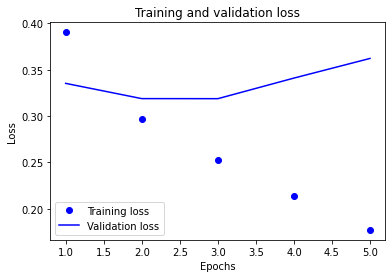

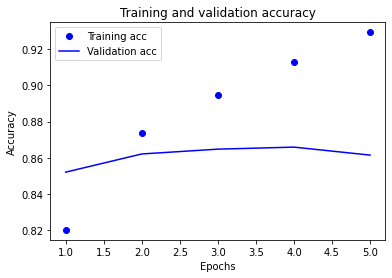

In [51]:
visualization(lstm_ko_history)

## Conv1D&한국어 Word2Vec

In [ ]:
class Conv1DModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.conv1 = keras.layers.Conv1D(64, 7, activation='relu')
        self.maxp = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(64, 7, activation='relu')
        self.gmaxp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.gmaxp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [ ]:
# model 선언
conv1d_model_ko = Conv1DModel_ko(embedding_matrix)

In [52]:
conv1d_ko_history = fitting_machine(conv1d_model_ko, 5)

Epoch 1/5
3427/3427 [==============================] - 19s 5ms/step - loss: 0.4262 - accuracy: 0.8002 - val_loss: 0.3582 - val_accuracy: 0.8416
Epoch 2/5
3427/3427 [==============================] - 18s 5ms/step - loss: 0.3156 - accuracy: 0.8653 - val_loss: 0.3316 - val_accuracy: 0.8553
Epoch 3/5
3427/3427 [==============================] - 18s 5ms/step - loss: 0.2668 - accuracy: 0.8883 - val_loss: 0.3438 - val_accuracy: 0.8565
Epoch 4/5
3427/3427 [==============================] - 18s 5ms/step - loss: 0.2218 - accuracy: 0.9099 - val_loss: 0.3679 - val_accuracy: 0.8549
Epoch 5/5
3427/3427 [==============================] - 18s 5ms/step - loss: 0.1748 - accuracy: 0.9307 - val_loss: 0.4278 - val_accuracy: 0.8465
1537/1537 - 3s - loss: 0.4411 - accuracy: 0.8439

This is conv1d_model_ko
Loss: 0.44110292196273804
Accurancy: 0.8438675999641418



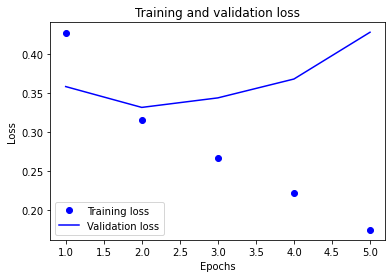

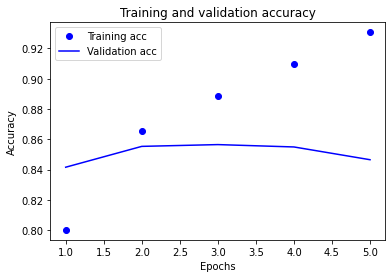

In [53]:
visualization(conv1d_ko_history)

## GMP with 한국어 Word2Vec

In [ ]:
class GMPModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.gmp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [ ]:
# model 선언
gmp_model_ko = GMPModel_ko(embedding_matrix)

In [54]:
gmp_ko_history = fitting_machine(gmp_model_ko, 5)

Epoch 1/5
3427/3427 [==============================] - 13s 4ms/step - loss: 0.5401 - accuracy: 0.7150 - val_loss: 0.4508 - val_accuracy: 0.7880
Epoch 2/5
3427/3427 [==============================] - 12s 4ms/step - loss: 0.4120 - accuracy: 0.8129 - val_loss: 0.4055 - val_accuracy: 0.8149
Epoch 3/5
3427/3427 [==============================] - 12s 4ms/step - loss: 0.3646 - accuracy: 0.8403 - val_loss: 0.3885 - val_accuracy: 0.8251
Epoch 4/5
3427/3427 [==============================] - 12s 4ms/step - loss: 0.3313 - accuracy: 0.8575 - val_loss: 0.3832 - val_accuracy: 0.8288
Epoch 5/5
3427/3427 [==============================] - 12s 4ms/step - loss: 0.3036 - accuracy: 0.8719 - val_loss: 0.3946 - val_accuracy: 0.8253
1537/1537 - 2s - loss: 0.3993 - accuracy: 0.8224

This is gmp_model_ko
Loss: 0.3993021547794342
Accurancy: 0.8223650455474854



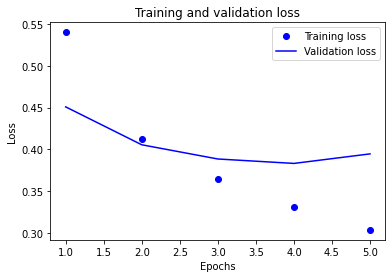

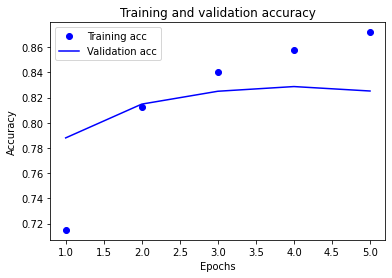

In [55]:
visualization(gmp_ko_history)

# 9) 회고

마지막 한국어word2vec을 하는 과정에서 gensim을 언인스톨하고 버전 3.8.1로 재설치하는 과정이 까다로웠다.<br><br>


**모델비교**<br>
LSTM: Loss=0.41, Accurancy=0.85
Lstm&한국어 Word2Vec: Loss=0.37, Accurancy: 0.85

Conv1D: Loss=0.59, Accurancy=0.84
Conv1D&한국어 Word2Vec: Loss=0.44, Accurancy=0.84

GMP: Loss=0.40, Accurancy: 0.83
GMP&한국어 Word2Vec: Loss=0.39, Accurancy: 0.82

<br><br>
LSTM과 Conv1D는 한국어 Word2Vec 임베딩을 사용하여 손실값이 감소되어 성능이 향상되었다.
GMP는 한국어 Word2Vec 임베딩을 사용하여 손실값이 감소하였지만 정확도가 약간 떨어졌다.